In [172]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import scriptinit
from scriptutils import *
import numpy as np
import numpy.linalg as npla
import numpy.random as npr
import matplotlib
import pylab as plt
import time
import pdb
from IPython.display import *
from gridworld import Grid, GridWorldMDP, GridWorld, GridWorldUltimate
from agent import ValueIterationSolver, TDLearner, DQN, RecurrentReinforceAgent
import nn

## Maze Progression

In [74]:
# create.
H = 5
W = 5
world = np.zeros((H, W))
html = maze_template(world)
HTML(html)

,,,,
,,,,
,,,,
,,,,
,,,,


In [75]:
# store.
save('world65', world)

In [29]:
# look up.
world = load('world25')
HTML(maze_template(world))

,,,,
,,,,
,,,,
,,,,
,,,,


In [76]:
htmls = []
for i in range(5):
    world = load('world6' + str(i+1))
    htmls.append(maze_template(world))
HTML(''.join(htmls))
    

,,,,
,,,,
,,,,
,,,,
,,,,
,,,,
,,,,
,,,,
,,,,
,,,,
,,,,


# Training

### create a progression of tasks

In [228]:
# maze shape
H = W = 5
gamma=0.9

# generate task progression.
def gen_tasks(worlds, wall_penalty=0., gamma=gamma):
    for world in worlds:
        grid = Grid(world, action_stoch=0.2)
        for num_goals in range(1,3):
            goal_pos_index = npr.choice(range(len(grid.free_pos)), num_goals, replace=False)
            goal = {grid.free_pos[ind]: 1 for ind in goal_pos_index}
            rewards = dict(goal)
            demons = {}
            yield GridWorldUltimate(grid, goal, demons, rewards, wall_penalty=wall_penalty, gamma=gamma)

tasks_ladder = map(gen_tasks, 
            [[np.zeros((H, W)) for i in range(1, 6)],
             map(load, ['world1' + str(i) for i in range(1, 6)]),
             map(load, ['world2' + str(i) for i in range(1, 6)]),
             map(load, ['world3' + str(i) for i in range(1, 6)]),
             map(load, ['world4' + str(i) for i in range(1, 6)]),
             map(load, ['world5' + str(i) for i in range(1, 6)]),
            ]
        )

# make dataset for supervised learning.
allow_init_pos_in_rewards = False
datasets = []
for tasks in tasks_ladder:
    dataset = []
    for task in tasks:
        values = solve_task_by_value_iteration(task)
        for pos in task.env.free_pos:
            if not allow_init_pos_in_rewards and pos in task.rewards:
                continue
            agent_state = np.zeros_like(task.env.grid)
            agent_state[pos] = 1.
            dataset.append((task.wrap_state(agent_state), values[pos]))
    datasets.append(dataset)
        
print 'dataset built, len = ', map(len, datasets)


dataset built, len =  [235, 225, 215, 205, 195, 185]


In [265]:
(train0, test0) = train_test_split(datasets[0], training_ratio=0.7)
def prepare_data_for_nn(data):
    '''
    take a list of examples [(x_i,y_i)] and turn into two arrays
        x (N x D): the variants.
        y (N x T): the co-varaints.
    '''
    x = np.array(list(zip(*data)[0]))
    x = x.reshape(x.shape[0], x.shape[1])
    y = np.array(zip(*data)[1]).reshape(-1, 1)
    return (x, y)
(x0, y0) = prepare_data_for_nn(train0)
(x0_t, y0_t) = prepare_data_for_nn(test0)
y0 = np.log(y0) / np.log(gamma)
y0_t = np.log(y0_t) / np.log(gamma)

In [267]:
fcn = nn.FCN([x0.shape[1], 32, 32, 1], l2_reg=0.0, step_size=1e-3)
fcn.train(x0, np.log(y0), num_iter=1000)
print 'training = ', np.sqrt(fcn.mse(x0, y0))
print 'mse = ', np.sqrt(fcn.mse(x0_t, y0_t))

Compiling fprop
Compiling backprop
done
training =  2.71170002539
mse =  2.8055727554


The problem with this approach: 

* input dataset too small, neural network overfits.
* neural network basically learns a tabular representation of $d(s,t)$.

**(IMPORTANT!!!) A new understanding of deep nn**
1. first extract invarant features of local inputs (e.g. convolutional filters).
2. composite different local features.

## NN with Decomposition

Compiling fprop
Compiling backprop
done
training =  1.02602275396
mse =  2.40492075732


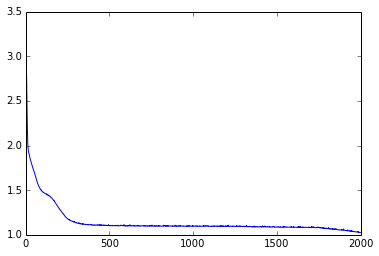

In [253]:
fcn = nn.GridWorldUltimateFCN(H * W, l2_reg=0.0, step_size=1e-3)
train_errors = []
for it in range(2000):
    fcn.train(x0, y0, num_iter=10)
    train_errors.append(np.sqrt(fcn.mse(x0, y0)))
plt.plot(train_errors)
print 'training = ', np.sqrt(fcn.mse(x0, y0))
print 'mse = ', np.sqrt(fcn.mse(x0_t, y0_t))

<matplotlib.colorbar.Colorbar instance at 0x10f674248>

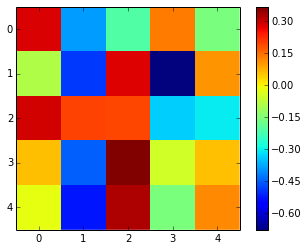

In [254]:
feat_i = 3
plt.imshow(fcn.model['fc_grid1'].params[0].get_value()[:, feat_i].reshape(5,5), interpolation='none')
plt.colorbar()

## NN with Decomposition + ConvLayer 

In [322]:
# sanity check of convlution layer.
from layers import Conv
import theano.tensor as T
import theano.tensor.signal.downsample as downsample
import theano
data = np.ones((141, 1, 5, 5))
data_t = T.tensor4('data')
conv = Conv(1, 5, filter_size = (2, 2), pool_size = (2,2), activation='relu')
output = conv(data_t)
f = theano.function(inputs=[data_t], outputs=[output])
f(data)[0].shape


(141, 5, 2, 2)

In [308]:
(train0, test0) = train_test_split(datasets[0], training_ratio=0.7)
def prepare_data_for_nn(data):
    '''
    take a list of examples [(x_i,y_i)] and turn into two arrays
        x (N x H x W x #Components): the variants.
        y (N x T): the co-varaints.
    '''
    x = np.array(list(zip(*data)[0]))
    new_xs = []
    for ni in range(x.shape[0]):
        new_x = np.zeros((4, H, W))
        for j in range(4):
            new_x[j, :, :] = x[ni, H * W * j:H * W * (j+1)].reshape(H, W)
        new_xs.append(new_x)
    new_xs = np.array(new_xs)
    y = np.array(zip(*data)[1]).reshape(-1, 1)
    return (new_xs, y)
(x0, y0) = prepare_data_for_nn(train0)
(x0_t, y0_t) = prepare_data_for_nn(test0)
y0 = np.log(y0) / np.log(gamma)
y0_t = np.log(y0_t) / np.log(gamma)

In [309]:
x0.shape

(141, 4, 5, 5)

Compiling fprop
Compiling backprop
done
training =  0.421229519474
mse =  2.24559007435


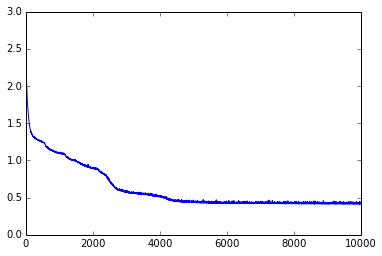

In [331]:
cnn = nn.GridWorldUltimateCNN(H, W, l2_reg=0.0, step_size=1e-3, 
                             F_AGENT_DIM1 = 3, F_AGENT_SIZE1 = (2,2), F_AGENT_POOL1 = (2,2))
train_errors = []
for it in range(10000):
    cnn.train(x0, y0, num_iter=10)
    train_errors.append(np.sqrt(cnn.mse(x0, y0)))
plt.plot(train_errors)
print 'training = ', np.sqrt(cnn.mse(x0, y0))
print 'mse = ', np.sqrt(cnn.mse(x0_t, y0_t))

Compiling fprop
Compiling backprop
done
training =  1.67178192411
mse =  1.81398020096


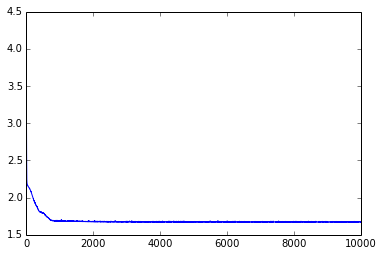

In [332]:
cnn = nn.GridWorldUltimateCNN(H, W, l2_reg=0.0, step_size=1e-3, 
                             F_AGENT_DIM1 = 3, F_AGENT_SIZE1 = (1,1), F_AGENT_POOL1 = (2,2))
train_errors = []
for it in range(10000):
    cnn.train(x0, y0, num_iter=10)
    train_errors.append(np.sqrt(cnn.mse(x0, y0)))
plt.plot(train_errors)
print 'training = ', np.sqrt(cnn.mse(x0, y0))
print 'mse = ', np.sqrt(cnn.mse(x0_t, y0_t))

In [ ]:
def run_one_episode(agent, task):
    '''
        run and train the agent through one episode on a given task.
    '''
    for trial in range(999999):
        if not task.is_terminal():
            break
        task.reset()
    
    curr_state = task.get_current_state()
    num_steps = 0.
    while True:
        num_steps += 1
        if num_steps > 200:
            print 'Lying and tell the agent the episode is over!'
            agent.end_episode(0)
            num_steps = 0.
        action = agent.get_action(curr_state)
        next_state, reward = grid_task.perform_action(action)
        total_reward += reward
        if grid_task.is_terminal():
            agent.end_episode(reward)
            break
        else:
            agent.learn(next_state, reward)
            curr_state = next_state
        
        if episode % diagnostic_frequency == 0:
            if diagnostic_callback is not None:
                print 'episode number: ',  episode
                error = diagnostic_callback(goal, rewards, total_reward)
                episodes.append(episode)
                errors.append(error)
                
    # plot convergence curve.
#     if errors:
#         plt.cla()
#         plt.plot(episodes, errors)
        # display.clear_output(wait=True)
#         display.display(plt.gcf())
#         plt.close()

In [ ]:
# set up the environment.
H = 5
W = 5
world = np.zeros((H, W))

goal_rewards_pairs = []
for ni in range(0, H, 2):
    for nj in range(0, W, 2):
        goal = np.zeros((H, W))
        goal[ni, nj] = 1.
        rewards = {(ni, nj): 1.}
        goal_rewards_pairs.append((goal, rewards))
(base_goal, base_rewards) = goal_rewards_pairs[0]
task = GridWorldWithGoals(grid, base_goal, base_rewards, wall_penalty=0., gamma=0.9)
_ = plt.imshow(solve_world_by_value_iteration(world, base_rewards), interpolation='none')

